In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

# from sklearn.preprocessing import StandardScaler
import sklearn

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

from utils import plot_projections

In [2]:
laser_dir = '/home/hashim/PHD/audio_data/Laser_Original_New/Laser_cleaned/'
laser_files = list(glob.glob(os.path.join(laser_dir, '*.mp3')))
laser_files.sort()
# print(laser_files)
print(len(laser_files))

72


In [3]:
orig_dir = '/home/hashim/PHD/audio_data/Laser_Original_New/Original_cleaned/'
orig_files = list(glob.glob(os.path.join(orig_dir, '*.mp3')))
orig_files.sort()
# print(orig_files)
print(len(orig_files))

74


In [4]:
%%capture
# compute spectograms for both laser and original
laser_spec = []

# laser_mu_feat = []
# laser_sigma_feat = []
# laser_beta_feat = []
X_laser = []
laser_label = []

for lf in laser_files:
    audio_data, sr = librosa.load(lf, res_type='kaiser_fast')
    stft = librosa.stft(audio_data, n_fft=256)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    
#     mu_feat = []
#     sigma_feat = []
#     beta_feat = []
    laser_feat = []
    for row in S_db:
        
        f = Fitter(row, distributions=["gennorm"])

        f.fit()
#         print(f.get_best(method = 'sumsquare_error'))

        f_param = f.fitted_param["gennorm"]
    
#         print(f_param)
#         print(f.summary())

#         mu_feat.append(f_param[1])
#         sigma_feat.append(f_param[2])
#         beta_feat.append(f_param[0])
        laser_feat.extend([f_param[1], f_param[2], f_param[0]])
        
#     laser_mu_feat.append(mu_feat)
#     laser_sigma_feat.append(sigma_feat)
#     laser_beta_feat.append(beta_feat)
    X_laser.append(laser_feat)
    laser_label.append('laser')
    
# laser_mu_feat = np.array(laser_mu_feat)
# laser_sigma_feat = np.array(laser_sigma_feat)
# laser_beta_feat = np.array(laser_beta_feat)

X_laser = np.array(X_laser)
laser_label = np.array(laser_label)


In [5]:
# print(S_db.shape)
# print(laser_mu_feat.shape)
# print(laser_sigma_feat.shape)
# print(laser_beta_feat.shape)
print(X_laser.shape)
print(laser_label.shape)

(72, 387)
(72,)


In [6]:
%%capture
orig_spec = []

# orig_mu_feat = []
# orig_sigma_feat = []
# orig_beta_feat = []
X_orig = []
orig_label = []
for of in orig_files:
    audio_data, sr = librosa.load(of, res_type='kaiser_fast')
    stft = librosa.stft(audio_data, n_fft=256)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    
#     mu_feat = []
#     sigma_feat = []
#     beta_feat = []
    orig_feat = []
    for row in S_db:
        
        f = Fitter(row, distributions=["gennorm"])

        f.fit()
#         print(f.get_best(method = 'sumsquare_error'))

        f_param = f.fitted_param["gennorm"]

#         mu_feat.append(f_param[1])
#         sigma_feat.append(f_param[2])
#         beta_feat.append(f_param[0])
        orig_feat.extend([f_param[1], f_param[2], f_param[0]])
        
#     orig_mu_feat.append(mu_feat)
#     orig_sigma_feat.append(sigma_feat)
#     orig_beta_feat.append(beta_feat)
    X_orig.append(orig_feat)
    orig_label.append('original')
    
# orig_mu_feat = np.array(orig_mu_feat)
# orig_sigma_feat = np.array(orig_sigma_feat)
# orig_beta_feat = np.array(orig_beta_feat)

X_orig = np.array(X_orig)
orig_label = np.array(orig_label)


In [7]:
# print(orig_mu_feat.shape)
# print(orig_sigma_feat.shape)
# print(orig_beta_feat.shape)

print(X_orig.shape)
print(orig_label.shape)

(74, 387)
(74,)


In [8]:
# X_orig = np.reshape(X_orig, (48, 129, 3))
# X_orig.shape

In [9]:
# X_laser = np.reshape(X_laser, (70, 129, 3))
# X_laser.shape

# SVM with Linear Kernel

In [10]:
clf = make_pipeline(StandardScaler(), LinearSVC())

In [11]:
X = np.concatenate((X_laser, X_orig))
X.shape

(146, 387)

In [12]:
y = np.concatenate((laser_label, orig_label))
y.shape

(146,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
X_train.shape

(97, 387)

In [15]:
y_train.shape

(97,)

In [16]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

In [17]:
y_pred = clf.predict(X_test)

In [18]:
print("accuracy = ", accuracy_score(y_test, y_pred))

accuracy =  0.8571428571428571


In [19]:
cm = confusion_matrix(y_test, y_pred)

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [21]:
(tn, fp, fn, tp)

(24, 2, 5, 18)

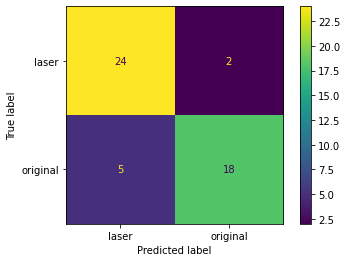

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# svm with non-linear kernal

In [23]:
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [24]:
clf_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [25]:
y_pred_svc = clf_svc.predict(X_test)

In [26]:
cm_svc = confusion_matrix(y_test, y_pred_svc)

In [27]:
tn, fp, fn, tp = cm_svc.ravel()

In [28]:
(tn, fp, fn, tp)

(16, 10, 0, 23)

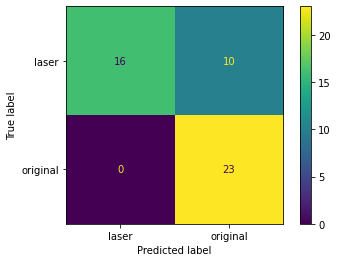

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=clf_svc.classes_)
disp.plot()